In [23]:
from pathlib import Path  
from matplotlib import pyplot as plot
from pathlib import Path  
import pandas as pandas
import numpy as numpy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [24]:
dataframe = pandas.read_csv("dataset.csv").dropna()
feature_names = ["Appliances","T1","RH_1","T2","RH_2","T3","RH_3","T4","RH_4","T5","RH_5","T6","RH_6","T7","RH_7","T8","RH_8","T9","RH_9","T_out","Press_mm_hg","RH_out","Windspeed","Visibility","Tdewpoint"]
dataframe = dataframe[feature_names]

X = dataframe.drop("Appliances", axis = 1)
y = dataframe["Appliances"]
TEST_SIZE_RATIO = 0.20
RANDOM_STATE_SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, random_state=RANDOM_STATE_SEED)

In [34]:
rfr_metrics_dataset_PATH = Path("./rfr_metrics_dataset.csv")
if not (rfr_metrics_dataset_PATH.exists() and rfr_metrics_dataset_PATH.is_file()):
    N_ESTIMATORS_SET = [1, 2, 3, 5, 8, 13, 21, 34, 55]
    performance = {}
    for n_estimators in N_ESTIMATORS_SET:
        print("\nTraining Random Forest Regression Model for n_estimators: %d" %n_estimators)
        # Applying Random Forest Regression model to the dataset.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
        random_forest_regressor = RandomForestRegressor(n_estimators = n_estimators, random_state=1, verbose = 1)
        random_forest_regressor.fit(X_train, y_train)

        # Calculate the metrics for the model.
        # Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
        y_pred = random_forest_regressor.predict(X)
        performance[n_estimators] = {
            "root_mean_square_error": mean_squared_error(y, y_pred, squared=False),
            "r2_score": r2_score(y, y_pred),
            "mean_absolute_error": mean_absolute_error(y, y_pred),
            "mean_absolute_percentage_error": mean_absolute_percentage_error(y, y_pred)
        }
    
    # Save the calculated metrics of the Random Forest Regression Model into the csv.
    csv_string = "\"n_estimators\",\"root_mean_square_error\",\"r2_score\",\"mean_absolute_error\",\"mean_absolute_percentage_error\""
    for n_estimators in performance.keys():
        csv_string = csv_string + "\n" + str(n_estimators) + "," + str(performance[n_estimators]["root_mean_square_error"]) + "," + str(performance[n_estimators]["r2_score"]) + "," + str(performance[n_estimators]["mean_absolute_error"]) + "," + str(performance[n_estimators]["mean_absolute_percentage_error"])
    random_forest_regression_metrics_dataset = open(rfr_metrics_dataset_PATH.name, "w")
    random_forest_regression_metrics_dataset.write(csv_string)
    random_forest_regression_metrics_dataset.close()

    # Save the importance of the feature w.r.t the most important feature and store the data into csv.
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_
    RFR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH = Path("./RFR_releative_feature_importance_dataset.csv")
    feature_importance = random_forest_regressor.feature_importances_
    releative_feature_importance = (feature_importance / feature_importance.max()) * 100
    sorted_indices=numpy.argsort(releative_feature_importance)
    pandas.DataFrame(data = {"feature_names": numpy.array(feature_names)[sorted_indices], "releative_feature_importance": releative_feature_importance[sorted_indices], "feature_importance": feature_importance[sorted_indices]}).to_csv(RFR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH.name)


Training Random Forest Regression Model for n_estimators: 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training Random Forest Regression Model for n_estimators: 2


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training Random Forest Regression Model for n_estimators: 3


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training Random Forest Regression Model for n_estimators: 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training Random Forest Regression Model for n_estimators: 8


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training Random Forest Regression Model for n_estimators: 13


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training Random Forest Regression Model for n_estimators: 21


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training Random Forest Regression Model for n_estimators: 34


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training Random Forest Regression Model for n_estimators: 55


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   20.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished


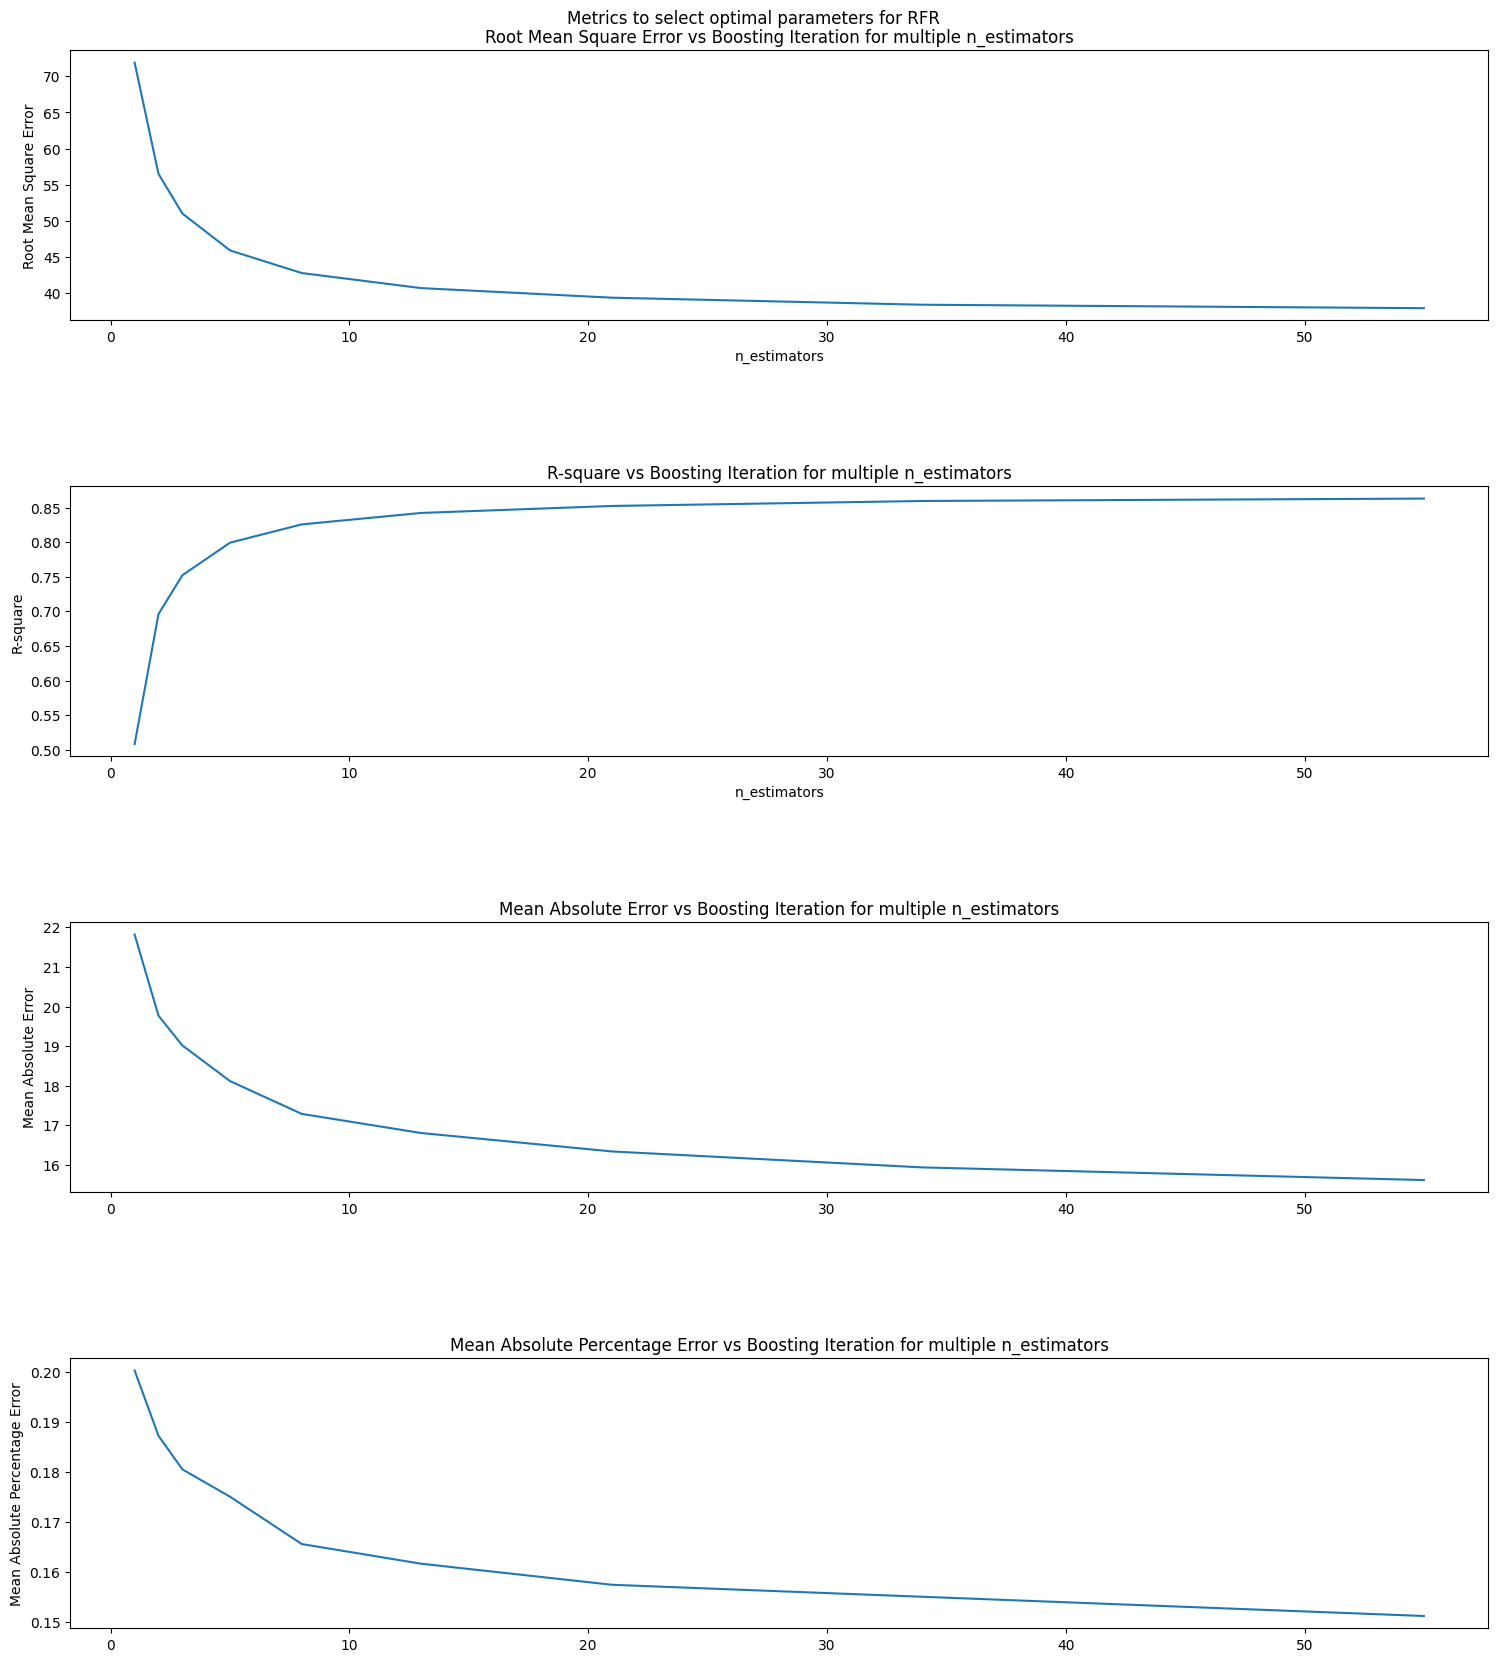

In [35]:
# Visualize model's metrics using line graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
rfr_metrics = pandas.read_csv(rfr_metrics_dataset_PATH.name)
figure, (plot1, plot2, plot3, plot4) = plot.subplots(4)
plot.tight_layout()

plot1.set_title("Root Mean Square Error vs Boosting Iteration for multiple n_estimators")
plot1.set_xlabel('n_estimators')
plot1.set_ylabel('Root Mean Square Error')
plot1.plot(rfr_metrics["n_estimators"], rfr_metrics["root_mean_square_error"])

plot2.set_title("R-square vs Boosting Iteration for multiple n_estimators")
plot2.set_xlabel('n_estimators')
plot2.set_ylabel('R-square')
plot2.plot(rfr_metrics["n_estimators"], rfr_metrics["r2_score"])


plot3.set_title("Mean Absolute Error vs Boosting Iteration for multiple n_estimators")
plot2.set_xlabel('n_estimators')
plot3.set_ylabel('Mean Absolute Error')
plot3.plot(rfr_metrics["n_estimators"], rfr_metrics["mean_absolute_error"])


plot4.set_title("Mean Absolute Percentage Error vs Boosting Iteration for multiple n_estimators")
plot2.set_xlabel('n_estimators')
plot4.set_ylabel('Mean Absolute Percentage Error')
plot4.plot(rfr_metrics["n_estimators"], rfr_metrics["mean_absolute_percentage_error"])

figure.set_figheight(18)
figure.set_figwidth(16)
figure.suptitle("Metrics to select optimal parameters for RFR")
figure.savefig("rfr_metrics_vs_iteration_for_multiple_n_estimators.png")
figure.show()

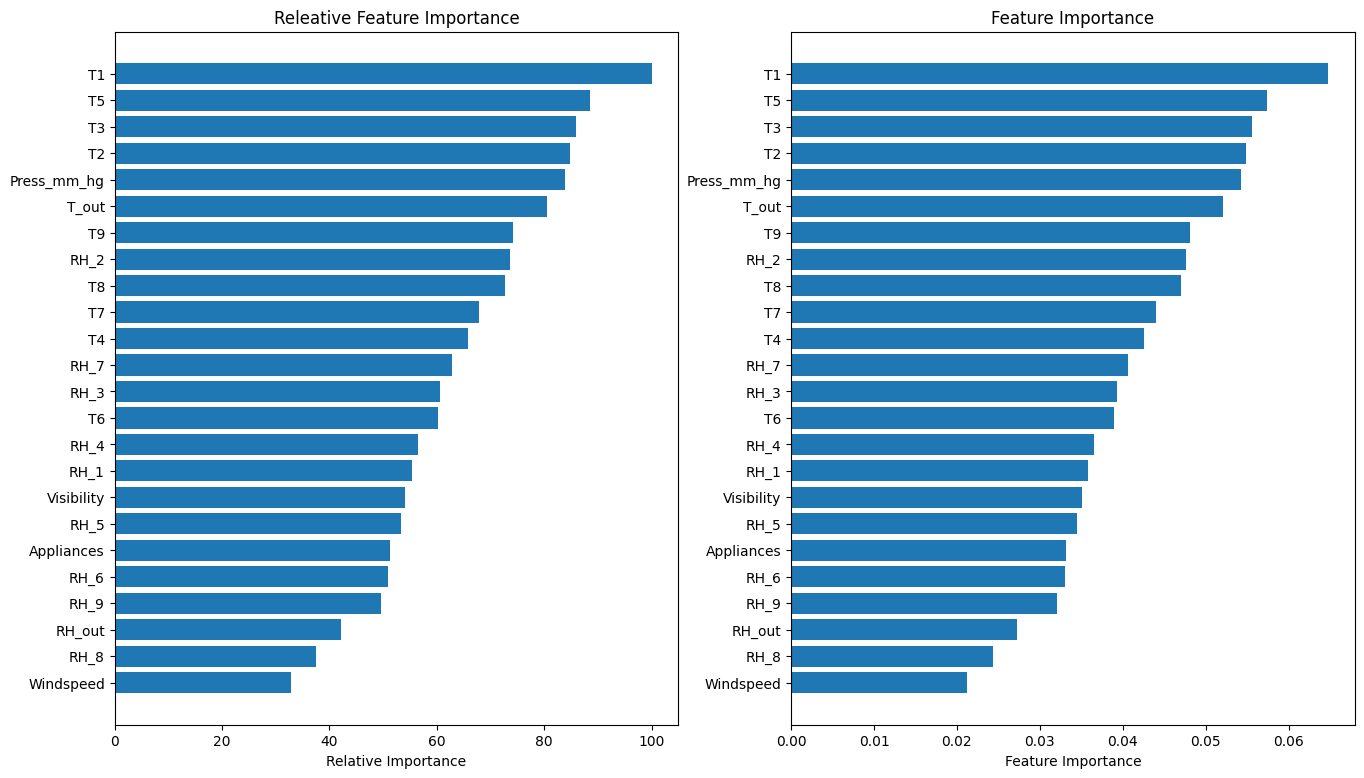

In [32]:
# Visualize feature importance of the model using bar graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
rfr_metrics = pandas.read_csv(RFR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH.name)

figure, (plot1, plot2) = plot.subplots(1, 2)

plot1.barh(rfr_metrics["feature_names"], rfr_metrics["releative_feature_importance"], align="center")
plot1.set_xlabel('Relative Importance')
plot1.set_title('Releative Feature Importance')

plot2.barh(rfr_metrics["feature_names"], rfr_metrics["feature_importance"], align="center")
plot2.set_xlabel('Feature Importance')
plot2.set_title('Feature Importance')

figure.set_figheight(9)
figure.set_figwidth(16)
figure.show()